In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Colab Notebooks/liar_dataset

/content/drive/MyDrive/Colab Notebooks/liar_dataset


In [14]:
# Standard library
import os
import numpy as np
import pandas as pd
from scipy.sparse import issparse
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import datasets, transforms, models
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# load dataset
train_df = pd.read_csv("train.tsv", sep='\t', header=None)
val_df = pd.read_csv("valid.tsv", sep='\t', header=None)
test_df = pd.read_csv("test.tsv", sep='\t', header=None)
column_names  = [
        'id', 'label', 'statement', 'subject', 'speaker', 'job', 'state', 'party',
        'barely_true_counts', 'false_counts', 'half_true_counts',
        'mostly_true_counts', 'pants_on_fire_counts', 'context']

train_df.columns = column_names
val_df.columns = column_names
test_df.columns = column_names

label_encoder = LabelEncoder()

# Encoding labels
train_labels = label_encoder.fit_transform(train_df['label'])
val_labels = label_encoder.transform(val_df['label'])
test_labels = label_encoder.transform(test_df['label'])

# extracting features
train_texts = train_df['statement'].astype(str)
val_texts = val_df['statement'].astype(str)
test_texts = test_df['statement'].astype(str)

# printing the first few rows of the dataset
print(f"Training data size: {len(train_texts)}")
print(f"Validation data size: {len(val_texts)}")
print(f"Test data size: {len(test_texts)}")


Training data size: 10240
Validation data size: 1284
Test data size: 1267


Training data size: 10240
Validation data size: 1284
Test data size: 1267

Label distribution in training set:
label
half-true      2114
false          1995
mostly-true    1962
true           1676
barely-true    1654
pants-fire      839
Name: count, dtype: int64

TF-IDF matrix shape (train): (10240, 5000)
Is TF-IDF matrix sparse? True

=== Logistic Regression Performance ===
              precision    recall  f1-score   support

 barely-true       0.26      0.20      0.23       212
       false       0.28      0.34      0.31       249
   half-true       0.23      0.28      0.26       265
 mostly-true       0.21      0.24      0.23       241
  pants-fire       0.31      0.05      0.09        92
        true       0.26      0.24      0.25       208

    accuracy                           0.25      1267
   macro avg       0.26      0.23      0.23      1267
weighted avg       0.25      0.25      0.24      1267

Macro F1 (test): 0.22691113137581498
Accuracy (test): 0.2494080505130229
ROC AU

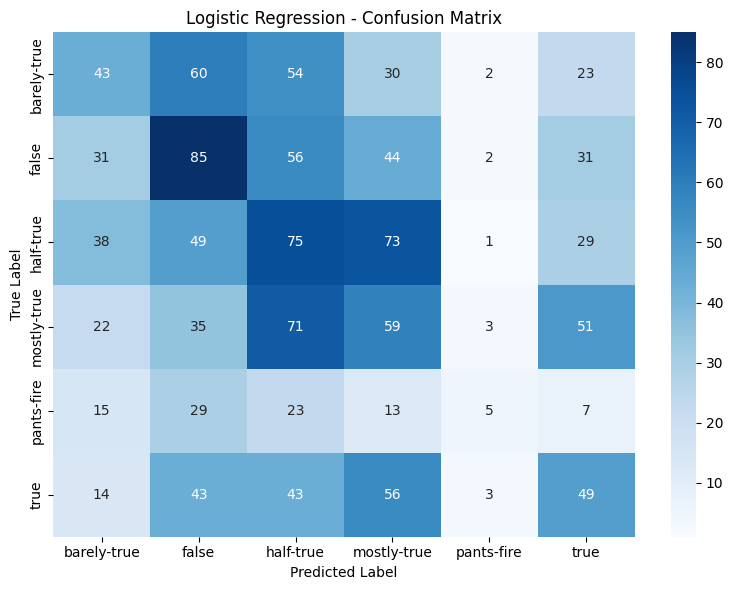

In [20]:
# === 1. Print Data Information ===
print(f"Training data size: {len(train_texts)}")
print(f"Validation data size: {len(val_texts)}")
print(f"Test data size: {len(test_texts)}")

# === 2. Print Label Distribution ===
print("\nLabel distribution in training set:")
print(train_df['label'].value_counts())

# === 3. TF-IDF Extraction ===
vectorizer = TfidfVectorizer(max_features=5000)
X_train = vectorizer.fit_transform(train_texts)
X_val = vectorizer.transform(val_texts)
X_test = vectorizer.transform(test_texts)

print("\nTF-IDF matrix shape (train):", X_train.shape)
print("Is TF-IDF matrix sparse?", issparse(X_train))

# === 4. Logistic Regression Model Training ===
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, train_labels)

# === 5. Logistic Regression Evaluation ===
test_preds_lr = lr.predict(X_test)
test_probs_lr = lr.predict_proba(X_test)

# Ensure test labels are correctly encoded
test_labels_bin = label_binarize(test_labels, classes=range(len(label_encoder.classes_)))

print("\n=== Logistic Regression Performance ===")
print(classification_report(test_labels, test_preds_lr, target_names=label_encoder.classes_))
print("Macro F1 (test):", f1_score(test_labels, test_preds_lr, average='macro'))
print("Accuracy (test):", accuracy_score(test_labels, test_preds_lr))
print("ROC AUC (OvR, test):", roc_auc_score(test_labels_bin, test_probs_lr, average='macro', multi_class='ovr'))

# Confusion Matrix
cm = confusion_matrix(test_labels, test_preds_lr)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Logistic Regression - Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()
